## Dataset Link : 
https://drive.google.com/drive/folders/1s7LQEJag6MiHTUmE4Db-yA7pRg51J1YZ?usp=sharing

In [1]:
import os
import random
import shutil
import pickle

import numpy as np

import PIL

import matplotlib.pyplot as plt

import torchvision
import torchvision.utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

from functorch import vmap
from functools import partial

from typing import Tuple, Iterable


In [2]:
### Helper Functions

# Showing images
def imshow(img, text=None):
    
    npimg = img.numpy()
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.axis("off")
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

    
def show_la_plot(loss_list,  accuracy_list):
    
    fig, ax1 = plt.subplots()

    # create a subplot for the current key
    # ax = fig.add_subplot(len(data1), 1, i+1)

    color = 'tab:green'
    ax1.set_xlabel('epoch',color=color)
    
    color = 'tab:red'
    ax1.plot(loss_list,color=color)
    ax1.set_ylabel('total loss',color=color)
    ax1.tick_params(axis='y', color=color)
        
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  
    ax2.plot( accuracy_list, color=color)
    ax2.tick_params(axis='y', color=color)

    ax1.set_title("loss vs acc")

    fig.tight_layout()

    
    # show the figure
    plt.show()
    
    
# visualizing one batch of data    
def visualize_images(pair_dataset, num_pairs):
    
    print("\n\nvisualising ", num_pairs, " data samples from the dataset\n")
    
    # Create a simple dataloader just for simple visualization
    vis_dataloader = DataLoader(pair_dataset, shuffle=True, batch_size=num_pairs)

    # Extract one batch
    example_batch = next(iter(vis_dataloader))

    concatenated = torch.cat((example_batch[0], example_batch[1]),0)

    imshow(torchvision.utils.make_grid(concatenated, nrow=num_pairs))
    
        
    
# computing the accuracy
def compute_accuracy(model, data_loader):
    
    correct = 0
    total = 0

    for img_q, img_s, true_label, _ in data_loader:
        
        true_label = torch.where(true_label > 1, torch.tensor([2]), true_label)
        
        similarity, logits = model(img_q, img_s)
        
        logits = torch.softmax(logits, dim=1)
        
        predicted_label = torch.argmax(logits, dim=-1)
        
        correct += (predicted_label == true_label).sum().item()
        total += true_label.size(0)
    
    accuracy = 100 * correct / total
    
    return accuracy


In [3]:
class PairDataset(Dataset):
    
    def __init__(self,dataset,transform=None,should_invert=True):
        self.dataset = dataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
                
        data0 = random.choice(self.dataset)

        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0, 1)
        
        if should_get_same_class:
            #keep looping till the same class image is found
            while True:
                data1 = random.choice(self.dataset)
                if data0[1] == data1[1]:
                    break
                    
        else:
            data1 = random.choice(self.dataset)

                    
        img0 = PIL.Image.fromarray(data0[0])
        img0_label = data0[1]
        
        img1 = PIL.Image.fromarray(data1[0])
        img1_label = data1[1]
            
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, img0_label, img1_label
        
    
    def __len__(self):
        return len(self.dataset)

In [4]:
class TripletDataset(Dataset):
    
    def __init__(self,dataset,transform=None,should_invert=True):
        self.dataset = dataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
                
        data0 = random.choice(self.dataset)
        
        #keep looping till the same class image is found
        while True:
            data1 = random.choice(self.dataset)
            if data0[1] == data1[1]:
                break
        
        #keep looping till a different class image is found
        while True:
            data2= random.choice(self.dataset)
            if data0[1] != data2[1]:
                break
       
                    
        img_anch = PIL.Image.fromarray(data0[0])
        img_pos = PIL.Image.fromarray(data1[0])
        img_neg = PIL.Image.fromarray(data2[0])
            
        if self.should_invert:
            img_anch = PIL.ImageOps.invert(img_anch)
            img_pos = PIL.ImageOps.invert(img_pos)
            img_neg = PIL.ImageOps.invert(img_neg)

        if self.transform is not None:
            img_anch = self.transform(img_anch)
            img_pos = self.transform(img_pos)
            img_neg = self.transform(img_neg)

        img_anch_label = data0[1]
        
        return img_anch, img_pos, img_neg, img_anch_label
        
    
    def __len__(self):
        return len(self.dataset)

In [5]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=0.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, similarity, label):
        
        loss_contrastive = torch.mean((1-label) * torch.pow(similarity, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - similarity, min=0.0), 2))
        
        return loss_contrastive
    

In [6]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, similarity_pos, similarity_neg):
        
        losses = torch.relu(similarity_pos - similarity_neg + self.margin)
        
        return losses.mean()

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self, cnn_layers: Iterable, linear_layers, out_channels: int):
        super().__init__()
        
        # pass in a NN
        self.cnn_layers = nn.Sequential(*cnn_layers)
        self.linear_layers = nn.Sequential(*linear_layers)
        
        
        # p can be change to induced norm (i.e., p = 1, p = 2)
        self.norm_fn = vmap(
            partial(torch.norm, p = 'fro')
        )
        
        #final linear layer to get prediction representation
        self.predictor = vmap(nn.Linear(1, out_channels))
        
        
    
    def forward(self, x_query: torch.Tensor, x_support: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward Pass:
            arg: Query Image (any image)
                 Support Image
        
        """
                
        x_query = self.cnn_layers(x_query)        
        x_support = self.cnn_layers(x_support)
        
        similarity = vmap(F.pairwise_distance)(x_query, x_support)[:, None]        
#         similarity = (self.norm_fn(x_query - x_support) + 1e-8)[:, None]

        logits = self.linear_layers(x_query.view(x_query.size()[0], -1))
            
        return similarity, logits


In [8]:
cnn_layers = [
    
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2),
]

linear_layers = [
    
    nn.Linear(64 * 3 * 3, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 2)
]

model = SiameseNetwork(cnn_layers, linear_layers, 2)

In [9]:
# Hyperparametes 

batch_size = 150
learning_rate = 0.01


In [10]:
# Loading the data

root = "datasets_for_comparison"

with open(root+'/accident_detection_train.pkl', 'rb') as f:
    accident_train_data = pickle.load(f)
with open(root+'/accident_detection_validation.pkl', 'rb') as f:
    accident_validation_data = pickle.load(f)
with open(root+'/accident_detection_test.pkl', 'rb') as f:
    accident_test_data = pickle.load(f)
    
print("Accident Train Data Size       = ", len(accident_train_data))
print("Accident Validation Data Size  = ", len(accident_validation_data))
print("Accident Test Data Size  = ", len(accident_test_data))


Accident Train Data Size       =  2938
Accident Validation Data Size  =  979
Accident Test Data Size  =  981




visualising  10  data samples from the dataset



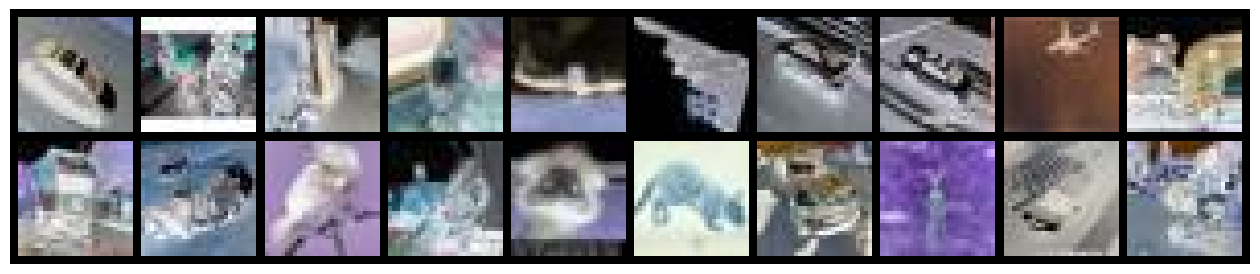



Batch Size    =  150
Train Batches =  20
Validation Batches  =  7




In [11]:

## Loading Data


transformation = transforms.Compose([transforms.Resize((28, 28)),
                                     transforms.ToTensor(),
                                    ])


# Load the training dataset

train_dataset = TripletDataset(accident_train_data, transform=transformation)
validation_dataset = PairDataset(accident_validation_data, transform=transformation)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
validation_loader = DataLoader(validation_dataset, shuffle=True, batch_size=batch_size)

visualize_images(validation_dataset, num_pairs=10)

print("\n")
print("Batch Size    = ", batch_size)
print("Train Batches = ", len(train_loader))
print("Validation Batches  = ", len(validation_loader))
print("\n")


In [12]:
# Training

criterion1 = ContrastiveLoss(margin=1)
criterion2 = nn.CrossEntropyLoss()
criterion3 = TripletLoss(margin=1)

global_max_acc = -1
best_lr = -1


optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-3)

counter = []
loss_history = [] 
acc_history = [] 

tot_iteration= 0

mx_acc = -1

for epoch in range(50):

    tot_loss = 0

    for i, (img_a, img_p, img_n, q_label) in enumerate(train_loader, 0):


        similarity_p, logits_a = model.forward(img_a, img_p)
        similarity_n, logits_a = model.forward(img_a, img_n)

        q_label = torch.where(q_label > 1, torch.tensor([2]), q_label)

        loss = criterion3(similarity_p, similarity_n) + criterion2(logits_a, q_label)

        tot_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#         if(tot_iteration%50 == 0):
#             print(f"Loss = {loss.item():.5f}")

        tot_iteration += 1


    tot_loss /= len(train_loader)
    accuracy = compute_accuracy(model, validation_loader)

    if(accuracy > mx_acc):
        mx_acc = accuracy
        torch.save(model.state_dict(), 'detection_best_model.pth')
    
    loss_history.append(tot_loss)
    acc_history.append(accuracy)

    print(f"Epoch {epoch} :: Curr Loss = {tot_loss:.5f}  :: Curr Acc = {accuracy:.5f}")



Epoch 0 :: Curr Loss = 1.39218  :: Curr Acc = 87.64045
Epoch 1 :: Curr Loss = 0.94230  :: Curr Acc = 91.52196
Epoch 2 :: Curr Loss = 0.77484  :: Curr Acc = 91.41982
Epoch 3 :: Curr Loss = 0.69507  :: Curr Acc = 91.21553
Epoch 4 :: Curr Loss = 0.65624  :: Curr Acc = 87.84474
Epoch 5 :: Curr Loss = 0.66629  :: Curr Acc = 90.29622
Epoch 6 :: Curr Loss = 0.55096  :: Curr Acc = 93.76915
Epoch 7 :: Curr Loss = 0.51223  :: Curr Acc = 93.66701
Epoch 8 :: Curr Loss = 0.52641  :: Curr Acc = 93.87130
Epoch 9 :: Curr Loss = 0.48088  :: Curr Acc = 93.66701
Epoch 10 :: Curr Loss = 0.48919  :: Curr Acc = 94.79060
Epoch 11 :: Curr Loss = 0.47427  :: Curr Acc = 94.38202
Epoch 12 :: Curr Loss = 0.45213  :: Curr Acc = 93.05414
Epoch 13 :: Curr Loss = 0.41532  :: Curr Acc = 93.56486
Epoch 14 :: Curr Loss = 0.39007  :: Curr Acc = 92.03269
Epoch 15 :: Curr Loss = 0.35223  :: Curr Acc = 95.40347
Epoch 16 :: Curr Loss = 0.38001  :: Curr Acc = 92.03269
Epoch 17 :: Curr Loss = 0.38973  :: Curr Acc = 93.36057
Ep

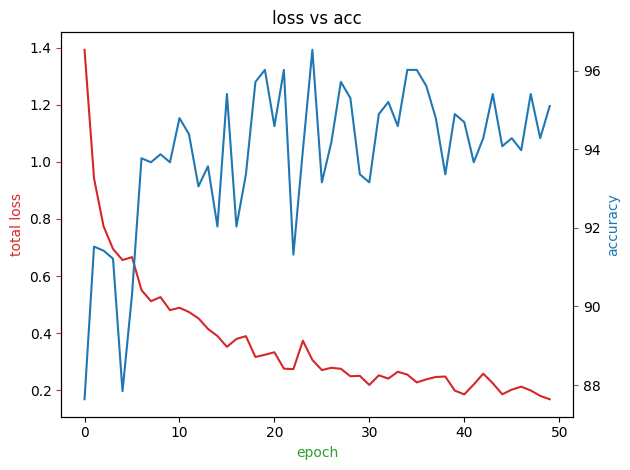

In [13]:
show_la_plot(loss_history, acc_history)

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

test_dataset = PairDataset(accident_test_data, transform=transformation)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

model.load_state_dict(torch.load('detection_best_model.pth'))

true_labels = []
predicted_labels = []

for img_q, img_s, true_label, _ in test_loader:
                
        similarity, logits = model(img_q, img_s)
        
        logits = torch.softmax(logits, dim=1)
        
        predicted_label = torch.argmax(logits, dim=-1)
        
        true_labels.extend(true_label.numpy())
        predicted_labels.extend(predicted_label.numpy())


precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
accuracy = accuracy_score(true_labels, predicted_labels)

print("\nOn Test Data\n")
print("Precision : ", precision)
print("Recall    : ", recall)
print("F1-score  : ", f1)
print("Accuracy  : ", accuracy)
print("\n\n")


On Test Data

Precision :  0.970685347878586
Recall    :  0.9702193770589997
F1-score  :  0.9704027756826067
Accuracy  :  0.9704383282364933



